In [70]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
import struct

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Microring resonator/LumericalFiles')) #Current directory

###############################################################
# WINDOWS PATH

#spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
#lumapi = importlib.util.module_from_spec(spec_win)
#os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
#sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Microring resonator/LumericalFiles/'))
#spec_win.loader.exec_module(lumapi)

## Lumapi init

In [71]:
ring = lumapi.FDTD(filename='RINGProject.fsp',hide=False) 

## Functions

In [72]:
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

## Assembly parameters

In [80]:
StRingLen = 0 # Length of straight sections of the ring
Radius = 3e-6 # Ring radius

StraightSpan = 10e-6 # Length of straight waveguides
Gap = 150e-9 # Gap between waveguides and the ring

BaseHeight = 0.22e-6 # height of the waveguide
BaseWidth = 0.5e-6 # width of the waveguide base

FPoints = 8        # Monitor frequency points

## Assembly

In [81]:
ring.switchtolayout()
ring.selectall()
ring.delete()
ring.addobject("ring_resonator")
ring.set({"x":-StraightSpan/2, "y":0, "z":0,
          "Lc":StRingLen,
          "x span":StraightSpan,
          "radius":Radius,
          "gap":Gap,
          "base height":BaseHeight,
          "base width":BaseWidth})

ring.setnamed("ring resonator::inner_bottom","enabled",0)
ring.setnamed("ring resonator::outer_bottom","enabled",0)
ring.setnamed("ring resonator::arc2","enabled",0)
ring.setnamed("ring resonator::arc3","enabled",0)

RectInsert(-StRingLen-Radius, BaseWidth, -Radius/4, Radius/2, 0, BaseHeight, "Si (Silicon) - Palik", ring)
ring.set("name","left leg")
RectInsert(StRingLen+Radius, BaseWidth, -Radius/4, Radius/2, 0, BaseHeight, "Si (Silicon) - Palik", ring)
ring.set("name","right leg")

ring.addfdtd()
ring.set({"x":0, "y":0.5*(Radius+3*BaseWidth+Gap - Radius/4), "z":0,
          "x span":StraightSpan, "y span":Radius+3*BaseWidth+Gap+Radius/2, "z span":3*BaseWidth,
          "background material": "SiO2 (Glass) - Palik",
          "mesh accuracy":4})

ring.addport()
ring.set({"x":-StraightSpan/2.5, "y":Radius+BaseWidth+Gap, "z":0,
          "y span":4*BaseWidth, "z span":2*BaseWidth})
ring.addport()
ring.set({"x":StraightSpan/2.5, "y":Radius+BaseWidth+Gap, "z":0,
          "y span":4*BaseWidth, "z span":2*BaseWidth,
          "direction":'Backward'})
ring.addport()
ring.set({"x":-StRingLen-Radius, "y":-Radius/4, "z":0,
          "injection axis":'y-axis', "x span":4*BaseWidth, "z span":2*BaseWidth})
ring.addport()
ring.set({"x":StRingLen+Radius, "y":-Radius/4, "z":0,
          "injection axis":'y-axis', "x span":4*BaseWidth, "z span":2*BaseWidth})

ring.select('FDTD::ports')
ring.set('monitor frequency points',FPoints)

ring.setglobalsource("wavelength start", 1.5e-6)
ring.setglobalsource("wavelength stop", 1.6e-6)

1.0

## Parameter sweeps

### Mesh sweep

In [82]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 5       # Sweep points
SRange = [2,6]  # Sweep range
Name = "Mesh_sweep"

# Sweep creation
ring.deletesweep(Name)
ring.addsweep(0)
ring.setsweep("sweep","name",Name)
ring.setsweep(Name,"type","Ranges")
ring.setsweep(Name,"number of points",SPoints)

MeshParameter = {"Name":"Mesh accuracy", "Type":"Number",
               "Parameter":"::model::FDTD::mesh accuracy",
               "Start":SRange[0], "Stop":SRange[1]}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

ring.addsweepparameter(Name,MeshParameter)
ring.addsweepresult(Name,Transmission_In)
ring.addsweepresult(Name,Transmission_Pass)
ring.addsweepresult(Name,Transmission_Drop)

ring.select('FDTD::ports')
ring.set('monitor frequency points',FPoints)

### Lc Sweep

In [83]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 10       # Sweep points
SRange = [0,3e-6]  # Sweep range
Name = "Lc_sweep"

# Sweep creation
ring.deletesweep(Name)
ring.addsweep(0)
ring.setsweep("sweep","name",Name)
ring.setsweep(Name,"type","Ranges")
ring.setsweep(Name,"number of points",SPoints)

LCParameter = {"Name":"LC", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::Lc",
               "Start":SRange[0], "Stop":SRange[1]}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

ring.addsweepparameter(Name,LCParameter)
ring.addsweepresult(Name,Transmission_In)
ring.addsweepresult(Name,Transmission_Pass)
ring.addsweepresult(Name,Transmission_Drop)

ring.select('FDTD::ports')
ring.set('monitor frequency points',FPoints)

### Gap & Lc sweep

In [84]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 5      # Sweep points
S1Range = [2e-6,5e-6]  # Sweep range 1
S2Range = [100e-9,1000e-9]  # Sweep range 2
Name = "LcGap_sweep"

S1Values = np.linspace(S1Range[0],S1Range[1],SPoints)
S2Values = np.linspace(S2Range[0],S2Range[1],SPoints)

# Sweep creation
ring.deletesweep(Name)
ring.addsweep(0)
ring.setsweep("sweep","name",Name)
ring.setsweep(Name,"type","Values")
ring.setsweep(Name,"number of points",SPoints**2)

LCParameter = {"Name":"LC", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::Lc"}

GapParameter = {"Name":"Gap", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::gap"}

for i in range(SPoints):
    for j in range(SPoints):
        LCParameter['Value_'+str(SPoints*j+i+1)] = S1Values[i]
        GapParameter['Value_'+str(SPoints*j+i+1)] = S2Values[j]

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

ring.addsweepparameter(Name,LCParameter)
ring.addsweepparameter(Name,GapParameter)
ring.addsweepresult(Name,Transmission_In)
ring.addsweepresult(Name,Transmission_Pass)
ring.addsweepresult(Name,Transmission_Drop)

ring.select('FDTD::ports')
ring.set('monitor frequency points',FPoints)

## Get sweep results

Transmission In: dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
Subset shape: (5, 5)
ParSet shape: (1, 5)
Transmission Pass: dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
Subset shape: (5, 5)
ParSet shape: (1, 5)
Transmission Drop: dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
Subset shape: (5, 5)
ParSet shape: (1, 5)


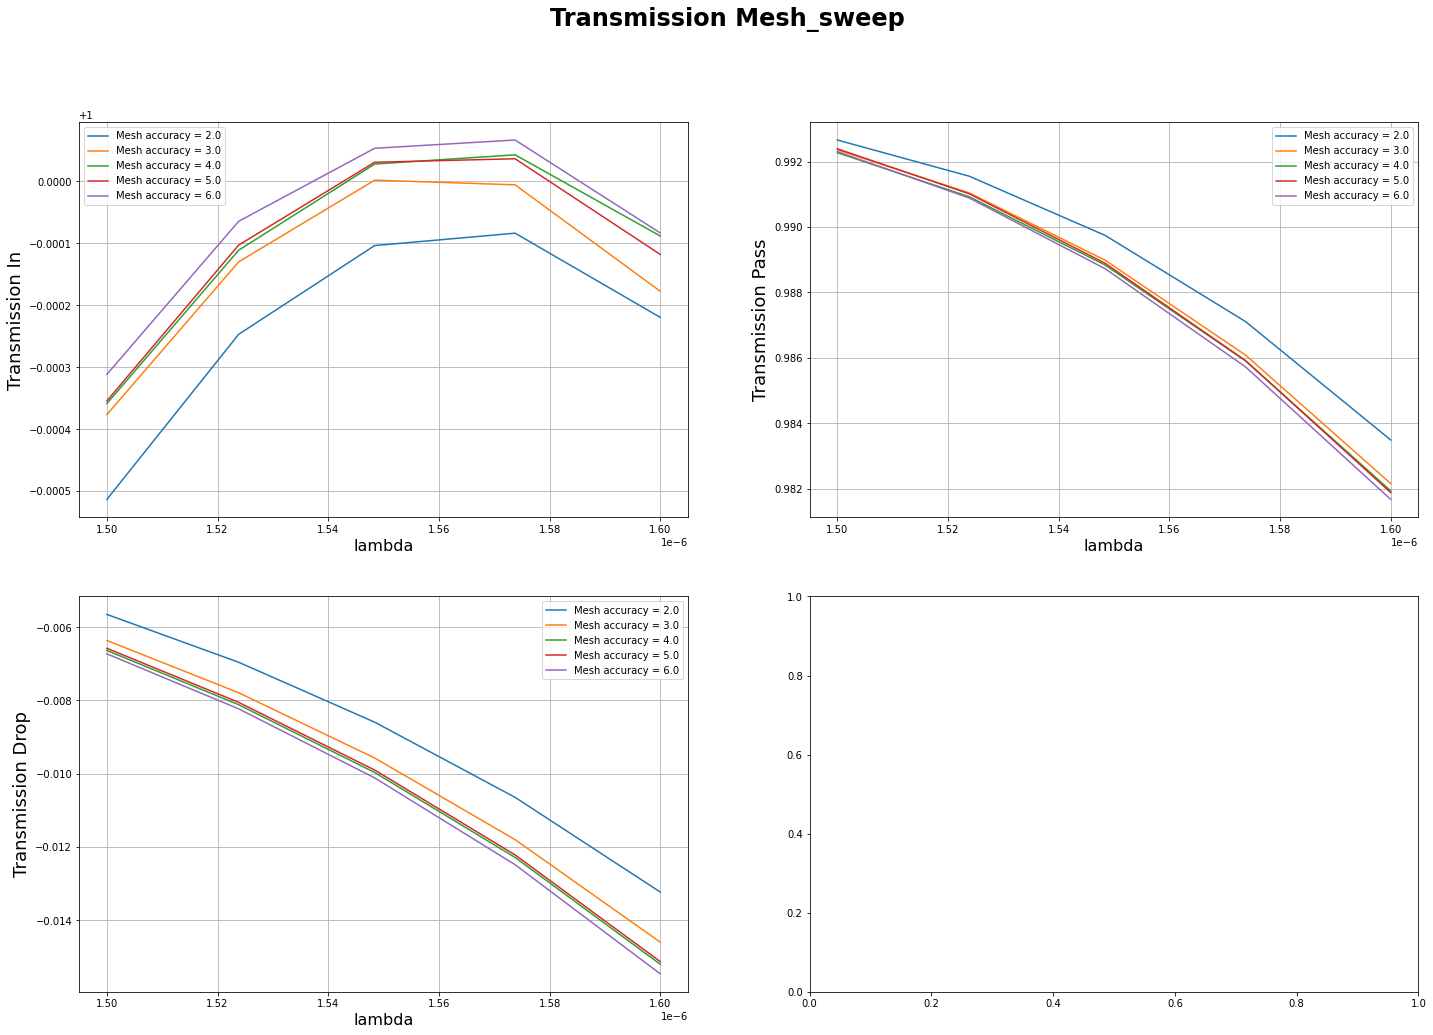

In [85]:
Name = "Mesh_sweep"
Parameters = ['Mesh accuracy','Mesh accuracy','Mesh accuracy'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)
Results = ['Transmission In','Transmission Pass','Transmission Drop']

winNum = int(1 + np.floor((len(Results) - 1)/2))  # Window line quantity
figure,ax=plt.subplots(2, 2, figsize=(24,winNum*8))
figure.suptitle('Transmission ' + str(Name),fontsize=24, fontweight="bold")

for i in range(len(Results)):
    dataSet = ring.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet = dataSet[Parameters[i]]
    gparSet = dataSet[gParameter]

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet shape: " + str(np.shape(parSet)))

    # Saving results
    completeName = os.path.join('../SavedData/MeshSweep','Data '+str(Results[i]))
    MSOutfile = open(completeName,'wb')
    plk.dump(subSet,MSOutfile)
    MSOutfile.close()

    completeName = os.path.join('../SavedData/MeshSweep','Data '+str(gParameter))
    MSOutfile = open(completeName,'wb')
    plk.dump(gparSet,MSOutfile)
    MSOutfile.close()

    completeName = os.path.join('../SavedData/MeshSweep','Data '+str(Parameters[i]))
    MSOutfile = open(completeName,'wb')
    plk.dump(parSet,MSOutfile)
    MSOutfile.close()

    for j in range(len(parSet[0,:])):
        ax[int(np.floor(i/2))][int(i%2)].plot(gparSet, np.transpose(subSet[:,j]), label=(str(Parameters[i])+' = '+str(round(parSet[0,j],9)) ))
        ax[int(np.floor(i/2))][int(i%2)].set_xlabel(gParameter, fontsize=16)
        ax[int(np.floor(i/2))][int(i%2)].set_ylabel(Results[i], fontsize=18)
        ax[int(np.floor(i/2))][int(i%2)].grid(True)
        ax[int(np.floor(i/2))][int(i%2)].legend(fontsize=10)
    
#plt.savefig("out.png", transparent=True)